# ZIFF Summer Internship 2017 Challenge Task 1: Improve accuracy with GridSearch

## Objective

Demonstrate an understanding of hyperperameter optimization using sklearn GridSearch on a convolutional deep net against a simplified MNIST digit regcognition by improving out-of-sample accuracy above 0.98398.

## Submission Criteria

  * Follow the instructions in Concepts > Challenge Submission in this project
  * Your solution must submitted by Friday June 9th 12:00 midnight

## Resources

  * [How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras](http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)
  * [Deep Learning for Developers](https://www.youtube.com/watch?v=lr3ZZAyHgsM)
  * [Lessons learned from 100 deep learning models](https://www.youtube.com/watch?v=HZfNlzziICQ)
  * [Machine Learning Mastery](http://machinelearningmastery.com/)

# Starter Script

In [1]:
%matplotlib inline
from __future__ import print_function
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np


Using TensorFlow backend.


In [2]:

batch_size = 128
num_classes = 2
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Only look at 3s and 8s
train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

x_train = x_train[train_picks]
x_test = x_test[test_picks]
y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (12223, 28, 28, 1)
12223 train samples
2060 test samples


# Util functions

In [3]:
def plot_accuracy(history):
    plt.plot(history['acc'])
    if 'val_acc' in history:
        plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def plot_loss(history):
    plt.plot(history['loss'])
    if 'val_loss' in history:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def plot_training(history):
    plot_accuracy(history)
    plot_loss(history)


class PlotHistoryCallback(keras.callbacks.History):
    def on_train_end(self, logs=None):
        plot_training(self.history)

In [16]:
def create_model(fc_neurons_number=40, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2))
    model.add(Flatten())
    model.add(Dense(fc_neurons_number, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

def train_model(model, batch_size=25):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=12, verbose=1, validation_data=(x_test, y_test), shuffle=True)
    plot_training(history.history)
    return model

def evaluate_model(model):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: %.4f%%' % (score[0]))
    print('Test accuracy: %.2f%%' % (score[1] * 100))
    return model

def train_and_evaluate_model(model, batch_size=25):
    model = train_model(model)
    return evaluate_model(model)

def cross_validation_with_plot(neurons_number=40, dropout=0.2, optimizer='adam', batch_size=35, cv=10):
    print('x_train len = {}, y_train len = {}'.format(len(x_train), len(y_train)))
    estimator = []
    model = KerasClassifier(build_fn=lambda: create_model(neurons_number=neurons_number, dropout=dropout, optimizer=optimizer),
                            epochs=12, batch_size=batch_size, verbose=1, shuffle=True)
    estimator.append(('mlp', model))
    pipeline = Pipeline(estimator)
    results = cross_val_score(pipeline, x_train, y_train, cv=cv, fit_params={'mlp__callbacks': [PlotHistoryCallback()]})
    print('results: ' + str(results))
    print('mean: %.2f%% (%.2f%%)' % (results.mean() * 100, results.std() * 100))
    return results

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 13s - loss: 0.0598 - acc: 0.9802 - val_loss: 0.0410 - val_acc: 0.9840
Epoch 2/12
12223/12223 [==============================] - 12s - loss: 0.0234 - acc: 0.9925 - val_loss: 0.0287 - val_acc: 0.9898
Epoch 3/12
12223/12223 [==============================] - 12s - loss: 0.0179 - acc: 0.9947 - val_loss: 0.0214 - val_acc: 0.9932
Epoch 4/12
12223/12223 [==============================] - 15s - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0189 - val_acc: 0.9937
Epoch 5/12
12223/12223 [==============================] - 15s - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0262 - val_acc: 0.9932
Epoch 6/12
12223/12223 [==============================] - 15s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.0233 - val_acc: 0.9922
Epoch 7/12
12223/12223 [==============================] - 14s - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0196 - val_acc: 0.9932
Epoch 8/12
12223/12223 [==============================]

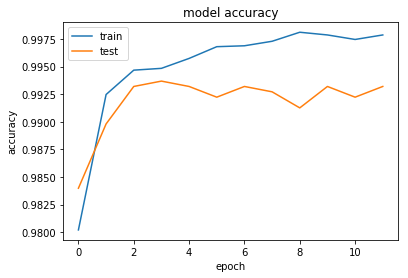

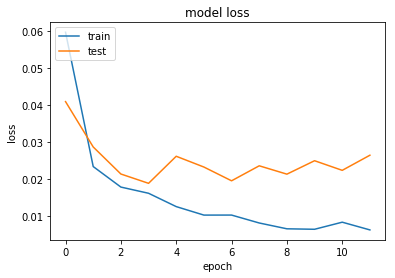

In [5]:
model = create_model(fc_neurons_number=80, dropout=0.3)
history = train_model(model)

In [17]:
model = evaluate_model(model)

Test loss: 0.0265%
Test accuracy: 99.32%


### grid_search_parameters function 
Function takes callbacks (if we want any) and params for GridSearchCV and return results.
It trains network and search for best params on defined above x_train and y_train which may be provided as function parameter, but for execution convenience they are global params. It uses defined above create_model function as build_fn for KerasClassifier wrapper.


### print_grid_search_result function 
Function takes results from GridSearchCV and print network hyperparameters that achieved best score.
Below it print all checked combinations with scores.

In [30]:
# default parameters for quick usage with default params: grid_search_parameters()
def grid_search_parameters(callbacks=[], params={'batch_size': [25, 35, 100],
                                                 'fc_neurons_number': ['40', '80'],
                                                 'dropout': [0.2, 0.3, 0.4]}):
    classifier = KerasClassifier(build_fn=create_model, epochs=12)
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=10, verbose=0, fit_params={'callbacks': callbacks,
                                                                                                      'validation_data': (x_test, y_test)})
    grid_search = grid_search.fit(x_train, y_train)
    return grid_search


def print_grid_search_result(results):
    best_index = results.best_index_
    cv_results = results.cv_results_
    print('best score = %f (+-%f)' % (results.best_score_, cv_results['std_test_score'][best_index]))
    print('best params: {}'.format(results.best_params_))
    print('all scores:')
    means = cv_results['mean_test_score']
    stds = cv_results['std_test_score']
    all_params = cv_results['params']
    for mean, stdev, params in zip(means, stds, all_params):
        print("%f (+-%f) with: %r" % (mean, stdev, params))


## Example usage of GridSearchCV for find best NN hyperparameters
With following params it may take some time because it will train Neural Network 10 x 2 x 2 x 3 = 120 times (10-cross validation, 2 x 2 x 3 - all possible combinations of provided parameters)

## Improving accuracy
To improve accuracy, many hyperparameters was searched by GridSearchCV, but below only few of them are shown due to time needed for search all of them at once.

Searched params:
 - optimizer
 - batch_size
 - fc_neurons_number
 - dropout values
 - activation function

After getting results, 'best parameters' where checked on cross_validation_with_plot function to visualize how loss and accuracy behave during training. Then model was tested on test_data which was unseen during that cross validation.

In baseline model, for sure, number of fully connected neurons are too low, that's why I decided to tune that hyperparameter. To not overfit the network with increased number of fc neurons, dropout was also tuned.

In [ ]:
grid_search_result = grid_search_parameters(params={'batch_size': [25, 64],
                  'fc_neurons_number': [40, 80],
                  'dropout': [0.2, 0.3, 0.4]})
print_grid_search_result(grid_search_result)

# Visualization of layers activations
Intermediate layers activations can show what Network sees at each level and if it can capture features of images. It might be helpful to verify if network works well. 

To visualize that below functions can be used.

Functions are flexible and can be used for any Keras CNN with image shape (width, height, channels) - in this example it's x_test[0].
They can be extracted and used in own code.


In [32]:
def get_activations_for_image(model, image):
    """feeding network with privided image and getting activations for each layer using K.function
    model - Keras model
    image - numpy array with shape: (width, height, channels)
    comp - tuple (intermediate_layer_function, layer_info)
    to get intermediate layer activation, each function is called with image and 0-flague for test mode (no dropout etc.)
    comp[1] is just layer_info for each layer - used in later visualization"""
    outputs = [(layer.output, layer_output_info(layer)) for layer in model.layers]
    graph = [(K.function([model.input] + [K.learning_phase()], [out[0]]), out[1]) for out in outputs]
    img = np.reshape(image, (1, *image.shape))
    return [(comp[0]([img, 0])[0], comp[1]) for comp in graph]

def layer_output_info(layer):
    """extracting output layer info for later visualization"""
    return 'Info: {}: {}'.format(layer.output.name, layer.output.shape[1:])

def display_activations(activations, conv_layers_number, max_number_of_imgs=36):
    """takes activations returned by get_activations_for_image function
    conv_layers_number - number of model layers to display - visualization of Fully Connected layers is not recommended
    max_number_of_imgs - default 36 images, max recommended filter activations to display"""
    print('Displaying activations for {} layers'.format(conv_layers_number))
    for i in range(conv_layers_number):
        layer = activations[i][0]
        layer = np.reshape(layer, [*layer.shape][1:4])
        imgs_number = min(layer.shape[-1], max_number_of_imgs)
        _display_act_for_layer(i, layer, activations[i][1], imgs_number)

def _display_act_for_layer(i, layer, layer_info, imgs_number):
    images_in_row = 6
    rows_number = np.math.ceil(imgs_number / images_in_row)
    fig, ax = plt.subplots(rows_number, images_in_row)
    fig.text(0, 1, 'Activation on layer {}: {}'.format(i+1, layer_info), fontsize=15) # displaying layer info
    if rows_number > 1:
        for i in range(imgs_number):
            ax[i // images_in_row, i % images_in_row].axis('off')
            ax[i // images_in_row, i % images_in_row].imshow(layer[:, :, i], 'hot')
        if imgs_number < rows_number * images_in_row:
            for i in range(imgs_number, rows_number * images_in_row):
                ax[i // images_in_row, i % images_in_row].axis('off')
    else:
        for i in range(imgs_number):
            ax[i].axis('off')
            ax[i].imshow(layer[:, :, i], 'hot')
        if imgs_number < images_in_row:
            for i in range(imgs_number, images_in_row):
                ax[i].axis('off')

# Case study
To show usage of the visualization I will  compare two CNN with different architectures. I will show example described here: http://cs231n.github.io/convolutional-networks/#layer-patterns

As stated in above notes: 
   
   "Prefer a stack of small filter CONV to one large receptive field CONV layer. Suppose that you stack three 3x3 CONV layers on top of each other (with non-linearities in between, of course). In this arrangement, each neuron on the first CONV layer has a 3x3 view of the input volume. A neuron on the second CONV layer has a 3x3 view of the first CONV layer, and hence by extension a 5x5 view of the input volume. Similarly, a neuron on the third CONV layer has a 3x3 view of the 2nd CONV layer, and hence a 7x7 view of the input volume. Suppose that instead of these three layers of 3x3 CONV, we only wanted to use a single CONV layer with 7x7 receptive fields. These neurons would have a receptive field size of the input volume that is identical in spatial extent (7x7), but with several disadvantages."
   
We will try to visualize if we can see difference, mentioned above, on MNIST example.

In [20]:
def model_case_study(one_conv):
    model = Sequential()
    if one_conv:
        model.add(Conv2D(16, kernel_size=(7, 7), activation='relu', input_shape=input_shape))
    else:
        model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(8, (3, 3), activation='relu'))
        model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

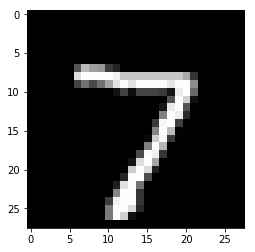

In [6]:
test_7 = x_test[0]
test_2 = x_test[1]
plt.imshow(np.reshape(test_7, (28,28)), 'gray')

## Three filters with size 3x3
Visualization of using model with 3 stacked conv layers with size 3x3.

In [21]:
multi_conv_model = model_case_study(one_conv=False)
multi_conv_model.layers

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 25s - loss: 0.0593 - acc: 0.9793 - val_loss: 0.0323 - val_acc: 0.9874
Epoch 2/12
12223/12223 [==============================] - 25s - loss: 0.0279 - acc: 0.9908 - val_loss: 0.0288 - val_acc: 0.9898
Epoch 3/12
12223/12223 [==============================] - 26s - loss: 0.0196 - acc: 0.9945 - val_loss: 0.0189 - val_acc: 0.9927
Epoch 4/12
12223/12223 [==============================] - 33s - loss: 0.0155 - acc: 0.9947 - val_loss: 0.0268 - val_acc: 0.9942
Epoch 5/12
12223/12223 [==============================] - 28s - loss: 0.0162 - acc: 0.9952 - val_loss: 0.0254 - val_acc: 0.9917
Epoch 6/12
12223/12223 [==============================] - 25s - loss: 0.0136 - acc: 0.9961 - val_loss: 0.0228 - val_acc: 0.9937
Epoch 7/12
12223/12223 [==============================] - 24s - loss: 0.0104 - acc: 0.9962 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 8/12
12223/12223 [==============================]

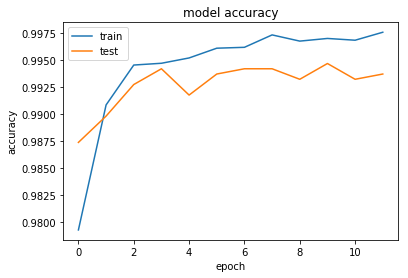

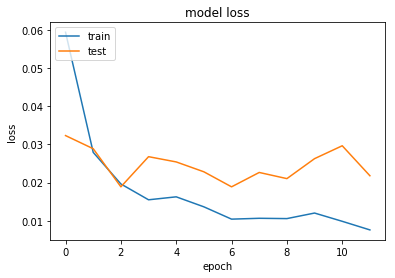

In [22]:
multi_history = train_model(multi_conv_model)

### Visualization multi conv layer for 2

Displaying activations for 4 layers


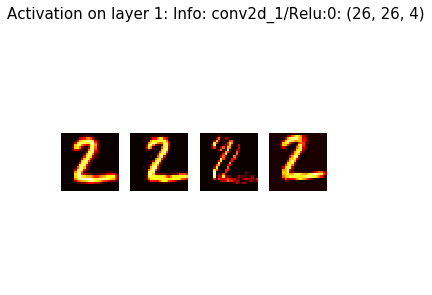

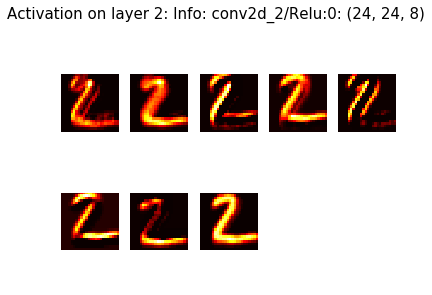

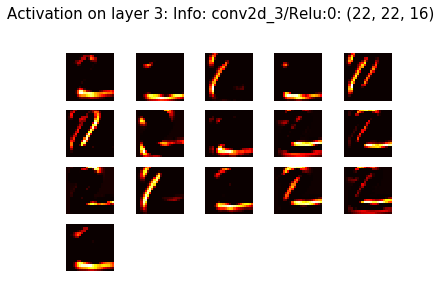

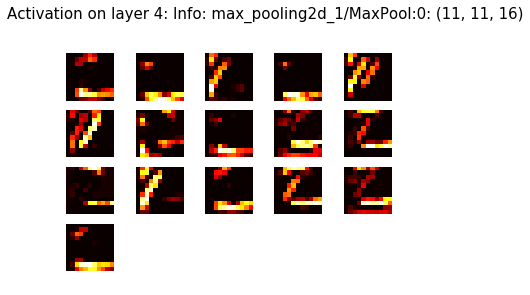

In [24]:
multi_activations = get_activations_for_image(multi_conv_model, test_2)
display_activations(multi_activations, 4) # displaying only activations on conv and max pooling layers

### Visualization one conv layer for 7

Displaying activations for 4 layers


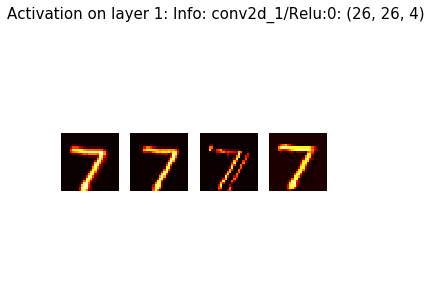

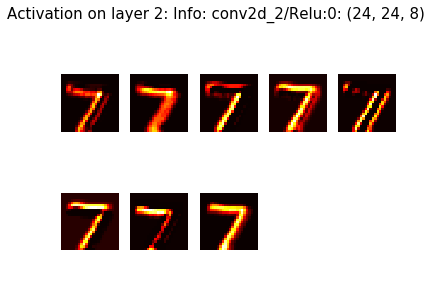

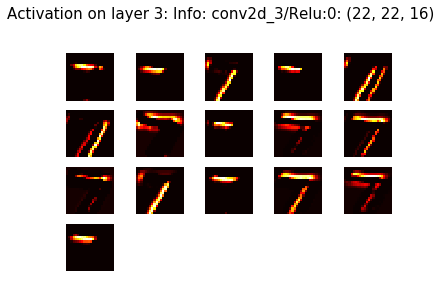

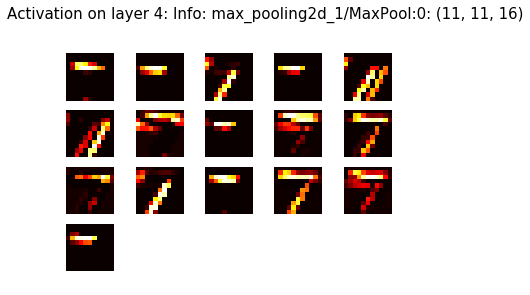

In [31]:
multi_activations = get_activations_for_image(multi_conv_model, test_7)
display_activations(multi_activations, 4) # displaying only activations on conv and max pooling layers

## One filter with size 7x7
Visualization of using model with one conv layer with size 7x7.

In [26]:
single_conv_model = model_case_study(one_conv=True)
single_conv_model.layers

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 18s - loss: 0.0552 - acc: 0.9795 - val_loss: 0.0380 - val_acc: 0.9854
Epoch 2/12
12223/12223 [==============================] - 18s - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0214 - val_acc: 0.9913
Epoch 3/12
12223/12223 [==============================] - 19s - loss: 0.0186 - acc: 0.9938 - val_loss: 0.0161 - val_acc: 0.9937
Epoch 4/12
12223/12223 [==============================] - 18s - loss: 0.0159 - acc: 0.9952 - val_loss: 0.0151 - val_acc: 0.9942
Epoch 5/12
12223/12223 [==============================] - 18s - loss: 0.0121 - acc: 0.9965 - val_loss: 0.0211 - val_acc: 0.9922
Epoch 6/12
12223/12223 [==============================] - 24s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0223 - val_acc: 0.9947
Epoch 7/12
12223/12223 [==============================] - 22s - loss: 0.0107 - acc: 0.9958 - val_loss: 0.0306 - val_acc: 0.9927
Epoch 8/12
12223/12223 [==============================]

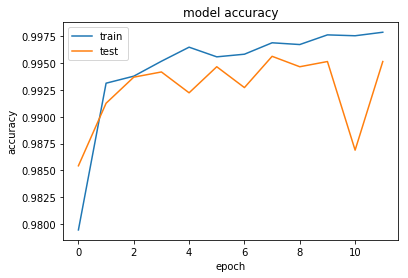

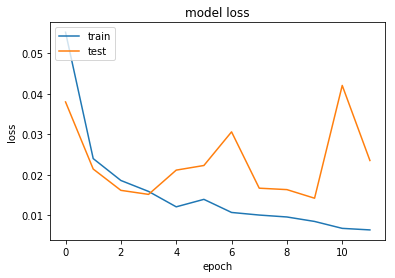

In [27]:
single_history = train_model(single_conv_model)

### Visualization one conv layer for 2

Displaying activations for 2 layers


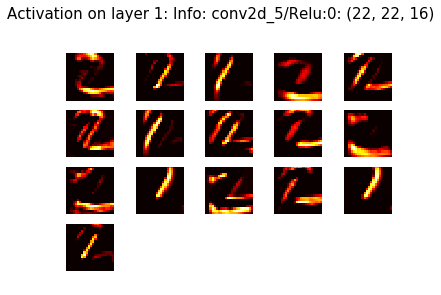

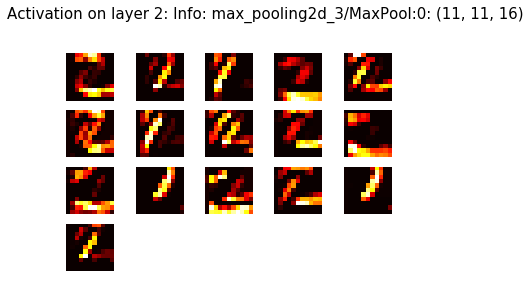

In [29]:
single_activations_2 = get_activations_for_image(single_conv_model, test_2)
display_activations(single_activations_2, 2, max_number_of_imgs=36) # displaying 36 out of 512

### Visualization one conv layer for 7

Displaying activations for 2 layers


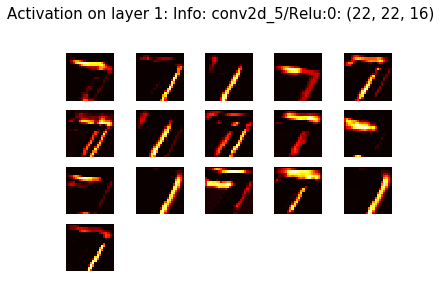

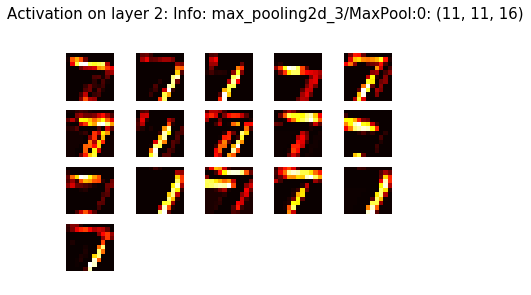

In [30]:
single_activations_7 = get_activations_for_image(single_conv_model, test_7)
display_activations(single_activations_7, 2, max_number_of_imgs=36)

## Summary
As you can see Multi_Conv_NN seems to have more specialized neurons (in lasts layers) that activates on certain features (horizontal lines, curves) than Single_Conv_NN. 

It is quite simple example (MNIST) and also both architectures have quite good accracy. To decide (based on visualizations) which is truly better, both solutions should be tested on more complicated images.

# Cats/Dogs 'real world' example
CNN trained on 4000 cats and 4000 dogs images.
Images of size 64 x 64.
Network architecture (simple, only for visualization purpose)
 - Conv 32 x 32, 'relu'
 - MaxPooling2D 2 x 2
 - Conv 32 x 32, 'relu'
 - MaxPooling2D 2 x 2
 - FC - 128 neurons, 'relu'
 - FC - 2 neurons, sigmoid

Trained for 3 epochs (very expensive and time consuming for my computer).

Functions are used as in MNIST example:

dog = x_test[21]

cat = x_test[2]

display_activations(get_activations_for_image(classifier, dog), 4)

display_activations(get_activations_for_image(classifier, cat), 4)

Visualizations:

## Dog
<img src="imgs/dog_pic.jpeg">
### First Conv Layer activations
<img src="imgs/conv_1_dog.jpeg">
### First Max Pool Layer activations
<img src="imgs/max_pool_1_dog.jpeg">
### Second Conv Layer activations
<img src="imgs/conv_2_dog.jpeg">
### Second Max Pool Layer activations
<img src="imgs/max_pool_2_dog.jpeg">


## Cat
<img src="imgs/cat_pic.jpeg">
### First Conv Layer activations
Look at middle output at the bottom.
<img src="imgs/conv_1_cat.jpeg">
### First Max Pool Layer activations
<img src="imgs/max_pool_1_cat.jpeg">
### Second Conv Layer activations
<img src="imgs/conv_2_cat.jpeg">
### Second Max Pool Layer activations
<img src="imgs/max_pool_2_cat.jpeg">

## Summary
On above examples, clearly we can see that network activates on certain shapes of the animals. The deeper level of the layer, the more specific features activates neurons.
